## Deugging function of unity-based virtual reality rig

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep, isfile, exists
from os import mkdir, makedirs

In [2]:
from unityvr.preproc import logproc
from unityvr.viz import viz, utils

#### Construct data object from log file

In [3]:
#TODO: Add logging of 
# - frame rate
# - ball radius

In [20]:
dirName = "../sample/analogwrite/"
fileName = "Log_2021-01-26_18-39-02.json"

ftlog = 'fictrac-20210125_190300.dat'

setFramerate = 144

In [21]:
uvrTest = logproc.constructUnityVRexperiment(dirName,fileName)
uvrTest.printMetadata()

Metadata:

expid  :  test2ptrigger
experiment  :  try to read and write to NiDaq (read frame trigger, write start trigger manually), 144 Hz framerate
genotype  :  none
sex  :  na
flyid  :  na
date  :  2021-01-26
time  :  18-39-02
notes  :  none


/Users/haberkernh/Documents/GitHub/unityvr/unityvr/preproc/logproc.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nidDf.imgfFilt[np.isfinite(nidDf.imgfsig)] = medfilt(nidDf.imgfsig[np.isfinite(nidDf.imgfsig)])


### Check frame rate
#### Basic visualizations

In [22]:
framesDf = uvrTest.nidDf[['frame','time','dt']].drop_duplicates().reset_index(level=0)[['frame','time','dt']]

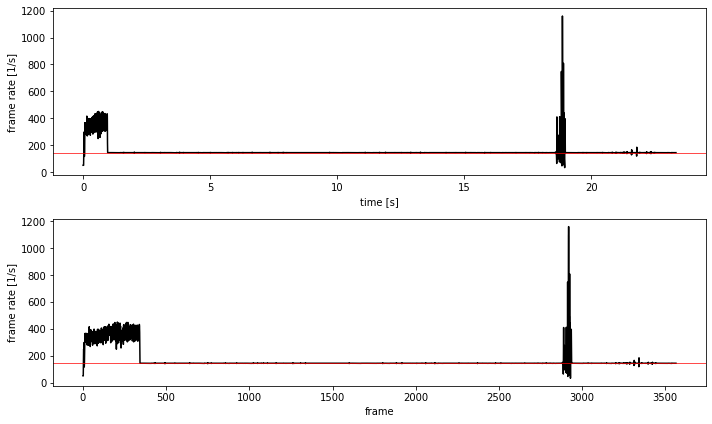

In [23]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(framesDf.time, 1/framesDf.dt, 'k')
ax[1].plot(framesDf.frame, 1/framesDf.dt, 'k')
for i in range(2):ax[i].axhline(setFramerate,0,1,color='r', linewidth=0.7)
utils.addlabs(ax, ['time [s]','frame'], ['frame rate [1/s]','frame rate [1/s]'])
fig.tight_layout()

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','framerate_'+fileName.split('.')[0]+'.pdf']))

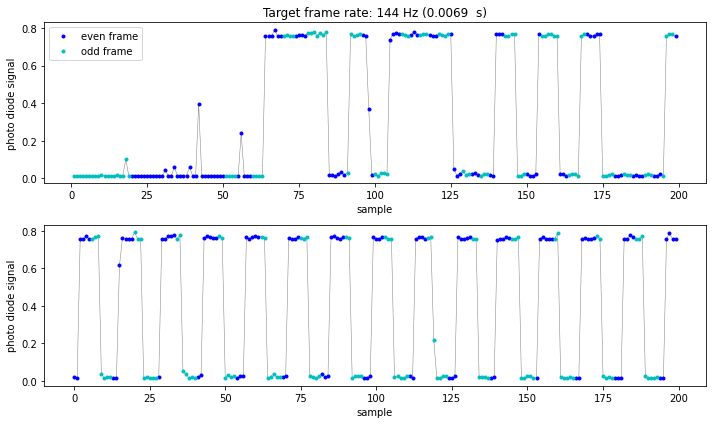

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 200
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(wind),uvrTest.nidDf.pdsig[ts:ts+wind],'-',color='grey',linewidth=0.5)
    
    even = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==1]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==1], even.pdsig, 'b.', label='even frame')
    
    odd = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==0]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==0], odd.pdsig, 'c.', label=
              'odd frame')
    
utils.addlabs(ax, ['sample','sample'], ['photo diode signal','photo diode signal'])
ax[0].legend()
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))
fig.tight_layout()

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photodiodeSig_evenframe_'+fileName.split('.')[0]+'.pdf']))

Visualization of delay

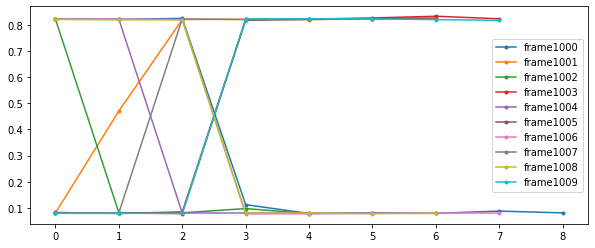

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
for f in range(1000,1010):
    sig = uvrTest.nidDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdsig)), sig.pdsig, '.-',  label='frame{}'.format(f))
ax.legend()

#### Quantification of frame rate variation

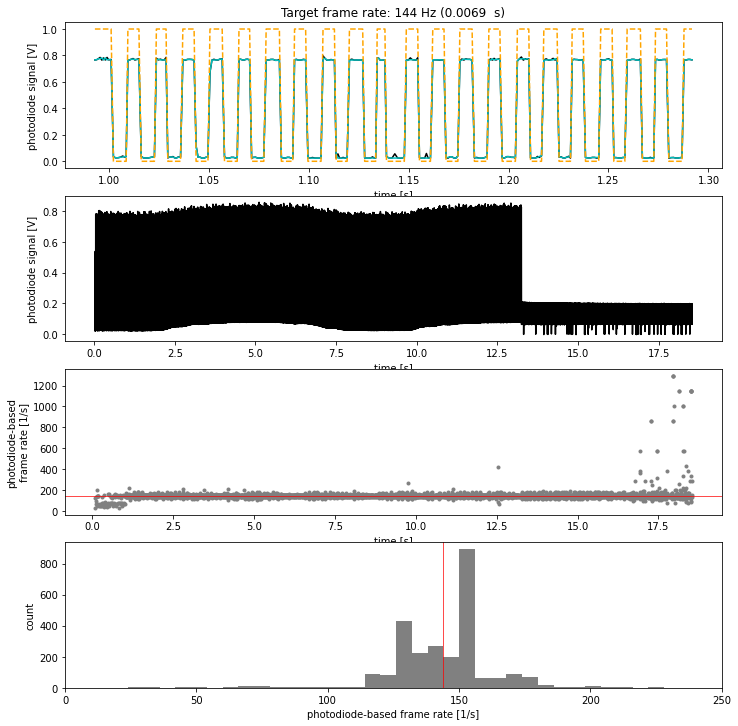

In [55]:
fig, ax = plt.subplots(4,1, figsize=(10,10))
ts = 1000
wind = 300
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdsig[ts:ts+wind], 'k')
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdFilt[ts:ts+wind], 'c')
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdThresh[ts:ts+wind], '--',color='orange')

pdChange = np.hstack((0,np.diff(uvrTest.nidDf.pdThresh)))
pdChangeT = uvrTest.nidDf.timeinterp.values[abs( pdChange )>0]

ax[1].plot(uvrTest.nidDf.timeinterp, uvrTest.nidDf.pdsig, 'k')

ax[2].plot(pdChangeT[1:], 1/np.diff(pdChangeT), '.', color='grey')
ax[2].axhline(setFramerate,0,1,color='r', linewidth=0.7)

ax[3].hist(1/np.diff(pdChangeT), bins=50, range=(0, 300), color='grey')
ax[3].set_xlim(0,250)
ax[3].axvline(setFramerate,0,1,color='r', linewidth=0.7)

ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))

fig.tight_layout()
utils.addlabs(ax, ['time [s]','time [s]','time [s]','photodiode-based frame rate [1/s]'],
    ['photodiode signal [V]','photodiode signal [V]','photodiode-based\nframe rate [1/s]','count'])

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photdiodeSignal_framerate_'+fileName.split('.')[0]+'.pdf']))

#### Relate unity-based and photodiode signal-based frame rate measures

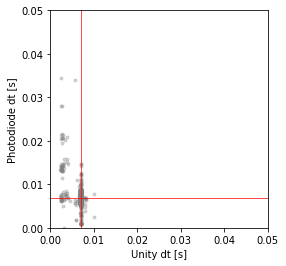

In [56]:
pdChangedt = uvrTest.nidDf.dt.values[abs( pdChange )>0]

fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.plot(np.roll(pdChangedt,0), np.hstack((0,np.diff(pdChangeT))), '.', color='grey', alpha=0.3)
#axs.plot(np.roll(pdChangedt,10), np.hstack((0,np.diff(pdChangeT))), 'r.', alpha=0.5)
axs.set_xlim(0,0.05)
axs.set_ylim(0,0.05)
axs.set_xlabel('Unity dt [s]')
axs.set_ylabel('Photodiode dt [s]')
axs.axvline(1/setFramerate,0,1,color='r', linewidth=0.7)
axs.axhline(1/setFramerate,0,1,color='r', linewidth=0.7)
axs.set_aspect('equal')
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','unityVsPhotodiode_framerate_'+fileName.split('.')[0]+'.pdf']))

### Compare unityVR trajectory with fictrac trajectory
#### Compare frame rates

Unity log frame rate: 152.59470043370544
Fictrac log frame rate: 118.33697322656313


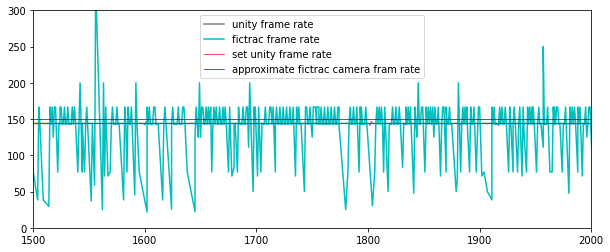

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(uvrTest.posDf.frame, 1/uvrTest.posDf.dt, color='grey', label="unity frame rate")
ax.plot(uvrTest.ftDf.frame,np.hstack([ 0, 1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.) ]), 'c-', label='fictrac frame rate')
print('Unity log frame rate: {}'.format(1/uvrTest.posDf.dt.mean()))
print('Fictrac log frame rate: {}'.format(1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.).mean()))
ax.set_xlim(1500,2000)
ax.set_ylim(0,300)
ax.axhline(setFramerate,0,1,color='r', linewidth=0.7, label='set unity frame rate')
ax.axhline(150,0,1,color='b', linewidth=0.7, label="approximate fictrac camera fram rate")
ax.legend()

#### Compare to fictrac data log

In [14]:
ftdat = pd.read_csv(sep.join([dirName, ftlog]), header=None)

In [59]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,19930265350380,0,0,6.858091e+07
1,1,-0.000585,-0.002038,-0.003280,4142.566469,-0.000500,-0.002627,0.002846,-0.000585,-0.002038,...,0.000503,6.280339,2.953652,0.002674,-0.002627,0.000500,19930272947467,1,7597087,6.858092e+07
2,2,0.006340,-0.000688,-0.002616,4158.724846,0.006413,-0.002121,0.001372,0.005753,-0.002715,...,-0.005902,6.278967,4.392923,0.006755,-0.004749,-0.005913,19930280544758,2,7597291,6.858092e+07
3,3,-0.007331,0.001305,0.006106,3936.976404,-0.007509,0.005281,-0.002907,-0.001573,-0.001415,...,0.001592,6.281874,0.957887,0.009180,0.000532,0.001596,19930288141804,3,7597046,6.858093e+07
4,4,0.006544,0.001314,0.005010,3950.950442,0.006393,0.004686,-0.002611,0.004975,-0.000105,...,-0.004801,0.001300,5.344932,0.007927,0.005218,-0.004797,19930295739093,4,7597289,6.858094e+07


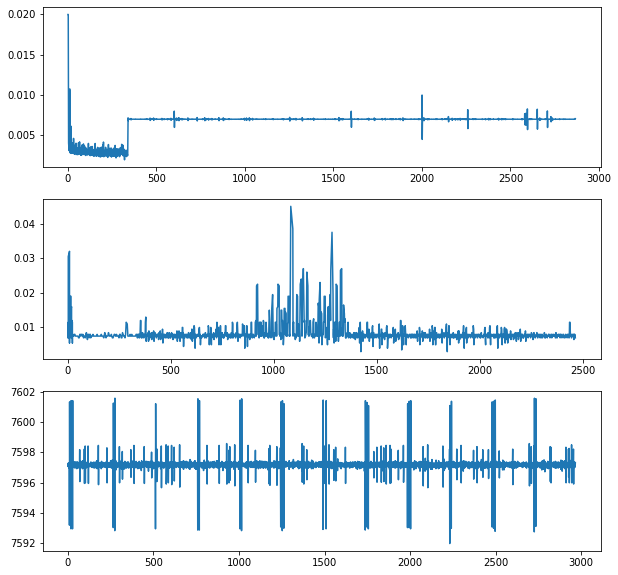

In [60]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame,uvrTest.posDf.dt)
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))

ftdt = ftdat[23].values/1000.
axs[2].plot(ftdat[0].values[1:-1], ftdt[1:-1])

#### Vizualize trajectory and object positions
ToDo: interpolate ft to get to frame rate of fictrac --> replace ftdf downsampling function

In [61]:
ballr = 40
convf = ballr #ballr*np.pi/180

fta = np.cumsum(uvrTest.ftDf['dz'])
fty = np.cumsum(convf*uvrTest.ftDf['dy']*np.cos(fta) - convf*uvrTest.ftDf['dx']*np.sin(fta))
ftx = np.cumsum(convf*uvrTest.ftDf['dy']*np.sin(fta) + convf*uvrTest.ftDf['dx']*np.cos(fta))

In [62]:
print(len(fta))
print(len(uvrTest.posDf['x']))

2108
2867


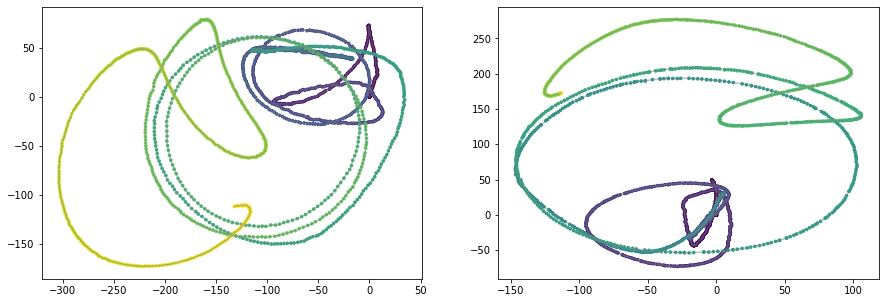

In [63]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

axs[0].plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
axs[0].scatter(ftx[0:3000], fty[0:3000],s=7,c=uvrTest.ftDf['frame'][0:3000],cmap='viridis')

axs[1].plot(uvrTest.posDf['x'], uvrTest.posDf['y'],color='grey',alpha=0.5)
axs[1].scatter(uvrTest.posDf['x'], uvrTest.posDf['y'],s=7,c=uvrTest.posDf['time'],cmap='viridis')

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','trajectoryComparison_'+fileName.split('.')[0]+'.pdf']))

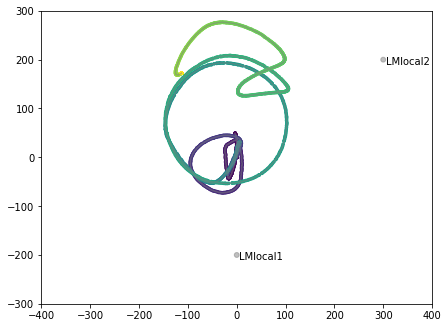

In [64]:
fig = viz.plotVRpathWithObjects(uvrTest, limx=[-400,400], limy=[-300,300],myfigsize=(7,7))

### Microscope trigger:

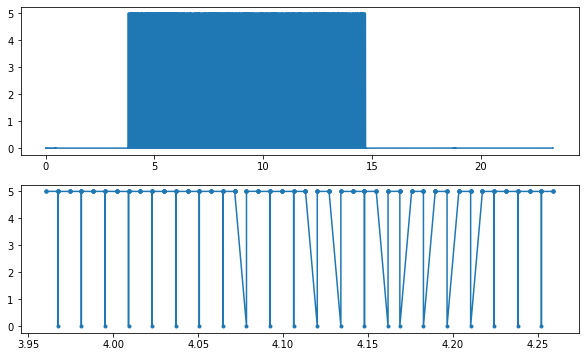

In [67]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 300
ts = 4000
ax[0].plot(uvrTest.nidDf.time.values,uvrTest.nidDf.imgfsig.values)
ax[1].plot(uvrTest.nidDf.time.values[ts:ts+wind],uvrTest.nidDf.imgfsig.values[ts:ts+wind],'.-')

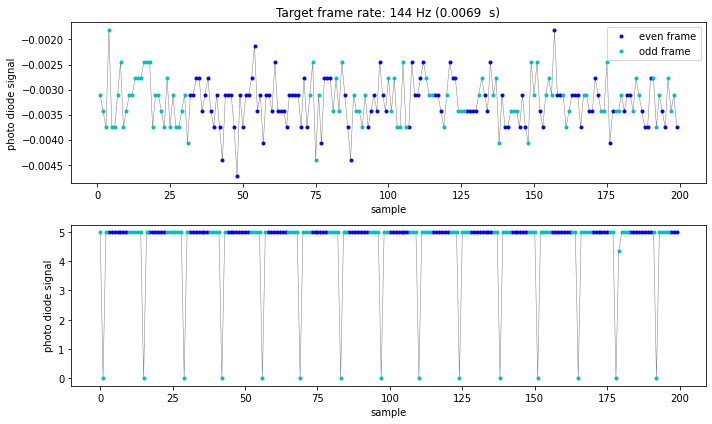

In [31]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 200
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(wind),uvrTest.nidDf.imgfsig[ts:ts+wind],'-',color='grey',linewidth=0.5)
    
    even = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==1]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==1], even.imgfsig, 'b.', label='even frame')
    
    odd = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==0]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==0], odd.imgfsig, 'c.', label=
              'odd frame')
    
utils.addlabs(ax, ['sample','sample'], ['photo diode signal','photo diode signal'])
ax[0].legend()
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))
fig.tight_layout()
